<a href="https://colab.research.google.com/github/CorsiIsa/Deep-And-Reinforcement-Learning/blob/master/rede_neural_recorrente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificando notícias utilizando Rede Neural Recorrente

As redes neurais recorrentes aprende com ela mesma (assim como nós humanos aprendemos com nossos erros). Esse tipo de arquitetura aprende não só com os dados de entrada mas também com as próprias saídas da rede (muito parecido com um looping de aprendizado, por isso chamamos de redes recorrentes).

# Importando as bibliotecas

In [61]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para NLP
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

# Para deep learning e validação do modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1L2


from tensorflow.keras.layers import (
    Embedding, Flatten, Dense, Dropout,
    Conv1D, SimpleRNN, Bidirectional, MaxPooling1D,
    GlobalMaxPool1D, LSTM, GRU
)


from keras.models import Sequential
from keras.regularizers import L1L2

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importando nossa base de dados

In [62]:
df = pd.read_csv("bbc-text.csv", sep=",")
df_2 = df.copy()

In [63]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [64]:
df.shape

(2225, 2)

Agora iremos verificar quais são os tipos de classificações presentes na nossa base, e se há valores nulos.

In [65]:
df['category'].nunique()

5

In [66]:
set(df['category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [67]:
df.isnull().sum()

,0
category,0
text,0


# Análise Exploratória

Agora iremos verificar se dessas 5 categorias nossa base atende de maneira equilibrada.

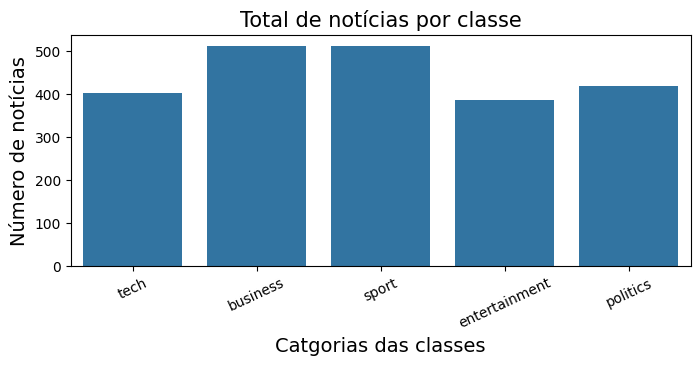

In [68]:
plt.figure(figsize=(8,3))
sns.countplot(data=df, x='category')
plt.title("Total de notícias por classe", size=15)
plt.xlabel("Catgorias das classes", size=14)
plt.xticks(rotation=25)
plt.ylabel("Número de notícias", size=14)
plt.show()

# Pré-Processamento

Quando trabalhamos com palavras precisamos realizar alguns tipos de tratamentos de dados:

* Tokenization (separar o texto em "tokens", ou seja, separar parte por parte).
* One-Hot encoding (representar variáveis categóricas como vetores binários).
* Pad sequencing (Garante sequências de comprimento uniforme adicionando zeros nas sequencias de palavas para manter sequencias uniformes)
* Embedding layer (Word2Vec) (mapear palavras em vetores)

# Limpeza dos dados

Agora iremos utilizar algumas funções para realizar essa limpeza:

* Regex: Pode ser definida como uma forma flexível de identificar determinada cadeia de caractere para nosso interesse. Uma cadeia pode ser um caractere específico, uma palavra ou um padrão. No Python, o módulo re provê um analisador sintático que permite o uso de tais expressões. Os padrões definidos através de caracteres que tem significado especial para o analisador.

* Stop-Words: Essa técnica consiste na remoção de ruídos do texto que são menos evidentes que pontuações, como os conectivos “que”, “o”, “a”, “de”, entre outros. Normalmente é um conjunto composto por artigos, advérbios, preposições e alguns verbos.

* Lematização: Basicamente é um processo que determina uma única “raiz” para a palavra, independente de suas diferenças superficiais.

In [69]:
def limpeza_texto(text):

    whitespace = re.compile(r"\s+")                            # encontrando espaços em branco
    user = re.compile(r"(?i)@[a-z0-9_]+")                      # encontrar menções de usuários, exemplo @usuario
    text = whitespace.sub(' ', text)                           # substitui espaços em branco por ' '
    text = user.sub('', text)                                  # remove todas as menções de usuário encontradas no texto
    text = re.sub(r"{}","", text)                              # remove o conteúdo dentro de colchetes, incluindo os colchetes
    text = re.sub("\d+", "", text)                             # remove todos os dígitos numéricos do texto
    text = re.sub(r'[^\w\s]','',text)                          # remove todos os caracteres que não são palavras (letras e números) ou espaços em branco.
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text) # remove menções de usuário, hashtags e URLs.
    text = text.lower()                                        # texto para minusculo


    text = [word for word in text.split() if word not in list(STOPWORDS)]

    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

Vamos validar para vê se realmente houve todos os tratamentos.

In [70]:
print("Texto antes da limpeza:\n",df['text'][0])
print("---"*100)
print("Texto depois da limpeza:\n",limpeza_texto(df['text'][0]))


Texto antes da limpeza:
 tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are als

Agora iremos aplicar em todo o nosso df

In [71]:
df['text'] = df['text'].apply(limpeza_texto)

In [72]:
antigo_total_caracter = df_2['text'].apply(len).sum()
novo_total_caracter = df['text'].apply(len).sum()

print(f"Tamanho de caracteres antes da limpeza: {antigo_total_caracter}")
print(f"Tamanho de caracteres depois da limpeza: {novo_total_caracter}")

Tamanho de caracteres antes da limpeza: 5035033
Tamanho de caracteres depois da limpeza: 3294641


# Realizando Tokenização e Vetorização

* Tokenização:
A tokenização é uma etapa inicial no processo de NLP para dividir frases de texto em palavras ou tokens menores. Por exemplo: "O time venceu a partida" ficaria "o", "time", "venceu", "a", "partida".

* Vetorização:
A máquina não entende texto ou palavras, portanto, dados de texto ou tokens devem ser convertidos em índices de palavras ou vetores de palavras para processar texto e construir modelos. Por exemplo, "o: 1", "time: 2", "venceu: 3", "a: 4", "partida: 5".

In [73]:
samples = list(df['text'][:5].values)  # amostras dos primeiros cinco documentos do nosso conjunto de dados

token_index = {} # cria um índice de tokens nos dados
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # atribuindo índice exclusivo para cada palavra única

max_length = 15 # Define um valor máximo para o comprimento das sequências.

results = np.zeros(shape=(len(samples),   # resultados serão armazenados neste array multidimensional de zeros com as dimensões obtidas pelo tamanho das amostras e o tamanho máximo de comprimento
                          max_length,     # Esta matriz será usada para armazenar a codificação one-hot das palavras em cada sequência de amostra
                          max(token_index.values()) +1))

print("Shape de resultados armazenados:", results.shape)
print("Índice de token de palavras únicas: \n", token_index)

# criando a matriz one hot econdig
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1


Shape de resultados armazenados: (5, 15, 680)
Índice de token de palavras únicas: 
 {'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 

# One Hot Enconding e indexação one-hot de dados de treinamento e teste

In [74]:
# Aplicando LabelEncoder nas categorias para converter rótulos de classes de texto ou categorias em números inteiros
X = df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

print("tamanho dos dados de entrada: ", X.shape)
print("tamanho da variável alvo: ", y.shape)

# Seprando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Criando a tokenização
# Tendo agora as palavras em uma grande lista (1000), usamos a classe Tokenizer para tokenização das palavras e criação de um vocabulário
# com as 1000 palavras mais frequentes no texto(parâmetro num_words do Tokenizer):
tokenizer = Tokenizer(num_words=1000, oov_token='<00V>')  # OOV = out of vocabulary (fora de vocabulário)
tokenizer.fit_on_texts(X_train) # construindo o índice de palavras

# Preenchimento de dados de entrada de texto X_train
train_seq = tokenizer.texts_to_sequences(X_train) #converte strings em listas inteiras
train_padseq = pad_sequences(train_seq, maxlen=200) # preenche as listas de inteiros para o tensor de inteiros 2D
# maxlen define o comprimento máximo desejado para as sequências após o preenchimento (padding)

# preenchimento de dados de entrada de texto X_test
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=200)

word_index = tokenizer.word_index
max_words = 1500  # número total de palavras a serem consideradas na camada de incorporação
total_words = len(word_index)
maxlen = 200 # comprimento máximo da sequência
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print("Tamanho do índice de palavras:", total_words)

tamanho dos dados de entrada:  (2225,)
tamanho da variável alvo:  (2225,)
Tamanho do índice de palavras: 22907


# Aplicando o Embeddings

Essa técnica consiste em transformar palavras em vetores, permitindo que o computador processe o significado semântico das palavras.

In [75]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=70, input_shape=(maxlen,))) # camada de embeddings, utilizando o total de palavras do corpus, com 70 neuronios de dimensão e entrada do tamanho da rede é de maxlen (200)
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # cada unidade de tempo da RNN tem acesso a informações de contexto tanto passadas quanto futuras
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True))) # return_sequences=True indica que essa camada retorna sequências em vez de um único vetor
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 70)        │     1,603,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 200, 128)       │        17,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 200, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,650,791 (6.30 MB)

 Trainable params: 1,650,791 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )
# Configurando early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Monitora a métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar sem melhorar a métrica monitorada antes de parar
                                              verbose=1, # mostra mensagens de progresso durante o treinamento
                                              mode='min' # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"
                                             )
# salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(
    filepath='bestvalue.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model.fit(train_padseq, y_train,
                   batch_size=120,
                    epochs=15,
                    validation_split=0.2
                   )

# validando o modelo
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 671ms/step - accuracy: 0.1899 - loss: 1.8089 - val_accuracy: 0.2191 - val_loss: 1.7172
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.2220 - loss: 1.7418 - val_accuracy: 0.2247 - val_loss: 1.7234
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.1943 - loss: 1.7398 - val_accuracy: 0.2191 - val_loss: 1.7126
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.2193 - loss: 1.6986 - val_accuracy: 0.2275 - val_loss: 1.6529
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.2227 - loss: 1.6868 - val_accuracy: 0.2219 - val_loss: 1.6378
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.2224 - loss: 1.6779 - val_accuracy: 0.2191 - val_loss: 1.6269
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step - accuracy: 0.2229 - loss: 1.6445 - val_accuracy: 0.2360 - val_loss: 1.6558
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.2462 - loss: 1.6480 - val_accuracy: 

O que pode ter ocorrido aqui nesse cenário é o vanishing gradient problem. Esse fenomeno ocorre quando o gradiente desaparece conforme ocorre o backpropagation. É isso que leva ao “esquecimento” das informações mais antigas devido às transformações pelas quais os dados passam ao atravessar uma RNN.

In [77]:
model.save("model.h5")

# Testando com LSTM, RNN e GRU

A rede neural LSTM Redes Long Short-Term Memory (memória de curto e longo prazo).
A GRU introduz mecanismos de portão que permitem que a rede aprenda quais informações devem ser lembradas e quais podem ser esquecidas durante o processamento de sequências, bem parecida com a LSTM

In [84]:
model2 = Sequential()
model2.add(Embedding(input_dim=total_words, output_dim=70, input_shape=(maxlen,)))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True))) # acrescentando camada LSTM
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer=L1L2(l1=1e-4, l2=1e-4))) # o GRU é projetado para superar o problema do desaparecimento de gradientes nas RNNs tradicionais e é especialmente eficaz em lidar com sequências de dados temporais.
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 200, 70)        │     1,603,490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 200, 128)       │        69,120 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 200, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 200, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 198, 72)        │        27,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 99, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 99, 64)         │         8,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857,903 (7.09 MB)

 Trainable params: 1,857,903 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:

model2.compile(optimizer='adam', # Adam, que é um algoritmo de otimização amplamente utilizado para ajustar os pesos da rede neural durante o treinamento.
            loss='categorical_crossentropy', # função de perda a ser minimizada durante o treinamento
            metrics=['accuracy'] # métrica de avaliação para monitorar durante o treinamento
            )
# Configurando early stopping
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', # Monitora a métrica de precisão durante o treinamento
                                             patience=3, # número de épocas que o treinamento pode continuar sem melhorar a métrica monitorada antes de parar
                                              verbose=1, # mostra mensagens de progresso durante o treinamento
                                              mode='min' # o treinamento é interrompido quando a métrica monitorada para de diminuir, no modo "min"
                                             )
# salva o modelo com os melhores valores encontrados durante o treinamento
checkpointer = ModelCheckpoint(filepath='bestvalue.keras', monitor='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# treinando o modelo
history = model2.fit(train_padseq, y_train,
                   batch_size=120,
                    epochs=15,
                    validation_split=0.2
                   )

# validando o modelo
test_loss, test_acc = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2059 - loss: 1.7474 - val_accuracy: 0.2163 - val_loss: 1.6898
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2098 - loss: 1.7298 - val_accuracy: 0.2163 - val_loss: 1.6788
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2274 - loss: 1.6954 - val_accuracy: 0.2135 - val_loss: 1.6765
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2233 - loss: 1.6884 - val_accuracy: 0.2219 - val_loss: 1.6720
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2202 - loss: 1.6787 - val_accuracy: 0.2051 - val_loss: 1.6739
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2327 - loss: 1.6745 - val_accuracy: 0.2107 - val_loss: 1.6712
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2068 - loss: 1.6738 - val_accuracy: 0.2135 - val_loss: 1.6629
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1898 - loss: 1.6791 - val_accuracy: 0.2135 - val_loss:

# Validando nosso segundo modelo

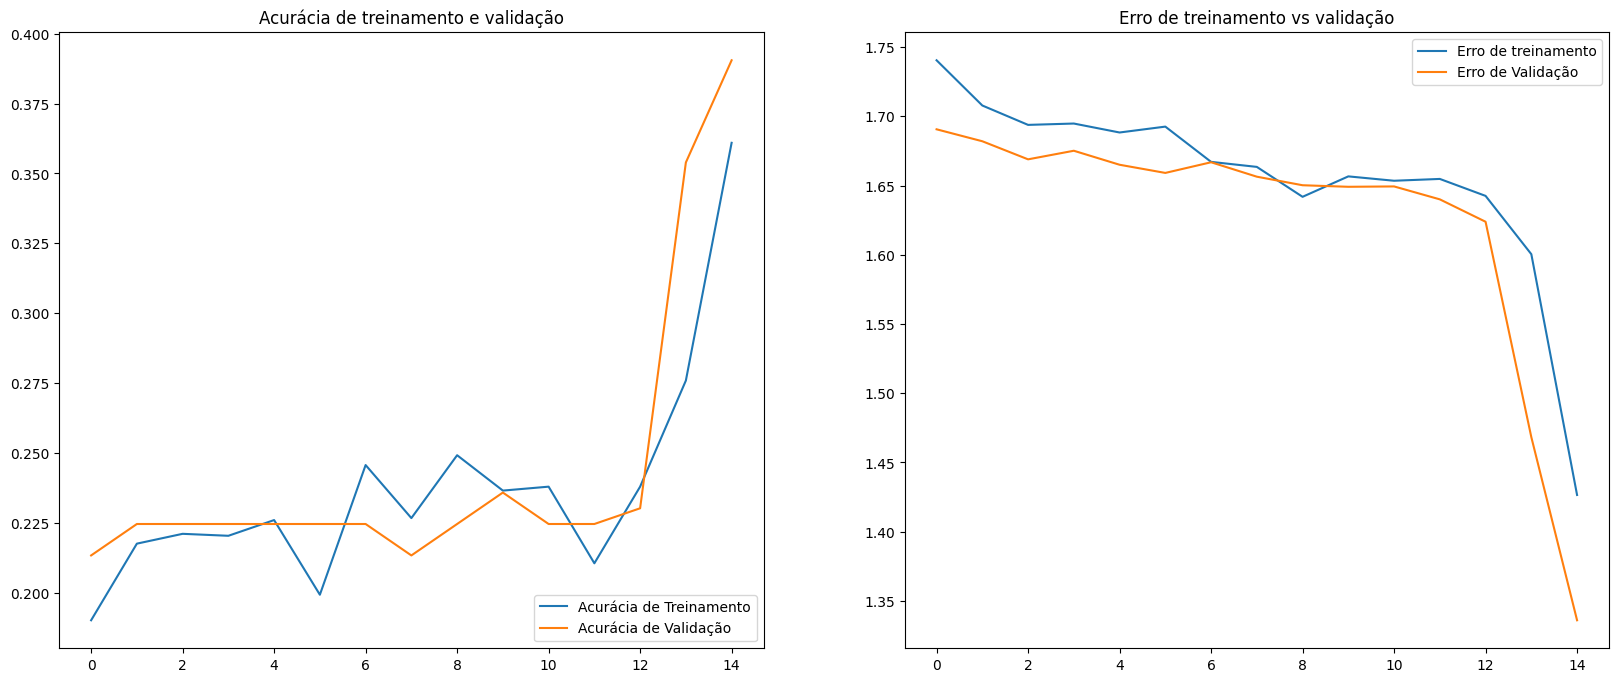

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [81]:
model.save("model2.h5") # salvando o modelo